ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ ОБРАЗОВАТЕЛЬНОЕ БЮДЖЕТНОЕ    
УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ    
«ФИНАНСОВЫЙ УНИВЕРСИТЕТ ПРИ ПРАВИТЕЛЬСТВЕ
РОССИЙСКОЙ ФЕДЕРАЦИИ»     
(ФИНАНСОВЫЙ УНИВЕРСИТЕТ)

Кафедра искусственного интеллекта
Факультета информационных технологий и анализа больших данных


Дисциплина: «Машинное обучение в семантическом и сетевом анализе»     
Направление подготовки: «Прикладная математика и информатика»      
Профиль: «Прикладное машинное обучение»       
Факультет информационных технологий и анализа больших данных      
Форма обучения очная       
Учебный 2024/2025 год, 6 семестр     

Курсовая работа на тему:
«Методы автоматического определения и исправления опечаток в учебных текстах и эссе»


Выполнила:
студентка группы ПМ22-4
Полищук О.Д.

Научный руководитель:
доцент Аллахвердов Р.А.


Москва 2025



---



Цель работы – исследование и сравнении существующих методов автоматического определения и исправления опечаток в учебных текстах и эссе, а также разработка и реализации собственного алгоритма, который позволит быстро и точно находить и исправлять ошибки такого рода.  

Для достижения поставленной цели необходимо решить следующие задачи:
*	провести обзор существующих методов автоматического исправления орфографических и пунктуационных ошибок;
*	выбрать наиболее перспективные методы, учитывая особенности сферы применения;
*	разработать и реализовать собственный алгоритм автоматического определения и исправления опечаток, основываясь на выбранном методе;
*	провести экспериментальную проверку разработанного алгоритма и оценить его эффективность по выбранным метрикам качества;
*	проанализировать полученные результаты и сформулировать выводы о преимуществах и недостатках используемого метода;
*	проанализировать практическую значимость и перспективы дальнейшего развития этой темы.

Объект исследования – учебные тексты и эссе, содержащие орфографические и пунктуационные ошибки. Предмет исследования – методы автоматического определения и исправления опечаток в учебных текстах, их сравнительный анализ и разработка алгоритма реализации метода.



---



Загружаем необходимые библиотеки для работы.

In [ ]:
!pip install datasets
!pip install evaluate
!pip install rouge_score
!pip install hf_xet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "L

In [ ]:
from datasets import load_dataset, Dataset
import pandas as pd
import numpy as np
import random
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Осуществляем загрузку и предварительную обработку датасета JFLEG, который широко используется для задач автоматической грамматической коррекции текста. Датасет содержит предложения с ошибками и несколько исправленных вариантов для каждого предложения, что позволяет обучать и оценивать модели исправления текста. В ходе работы же будет использоваться только 1 вариант исправления, т.к. в противном случае оперативная память будет перегружена.

Шаги:

1. статистический анализ: вычисление основных параметров, которые помогают понять структуру датасета — объём, среднюю длину предложений и количество исправлений, что важно для оценки сложности задачи;

2. предобработка текста: нормализация текстов за счёт приведения к нижнему регистру и удаления пунктуации; уменьшает шум и вариативность данных, что улучшает качество последующего обучения моделей;

3. обработка списков исправлений: каждый элемент списка с исправлениями обрабатывается отдельно, что обеспечивает корректную подготовку всех вариантов для обучения или оценки моделей.



In [ ]:
dataset = load_dataset("jhu-clsp/jfleg")
df = pd.DataFrame(dataset['validation'])

print("Пример данных:")
print("Оригинальный текст с ошибками:", df['sentence'][0])
print("Исправленные варианты:", df['corrections'][0])

print("\nОписание датасета:")
print(f"Количество примеров: {len(df)}")
print(f"Средняя длина предложения: {np.mean([len(s.split()) for s in df['sentence']]):.2f} слов")
print(f"Среднее количество исправлений на предложение: {np.mean([len(c) for c in df['corrections']]):.2f}")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df['processed_sentence'] = df['sentence'].apply(preprocess_text)
df['processed_corrections'] = df['corrections'].apply(lambda x: [preprocess_text(c) for c in x])

print("\nПример после предобработки:")
print("Оригинал:", df['processed_sentence'][0])
print("Исправления:", df['processed_corrections'][0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.94k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/141k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/755 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/748 [00:00<?, ? examples/s]

Пример данных:
Оригинальный текст с ошибками: So I think we can not live if old people could not find siences and tecnologies and they did not developped . 
Исправленные варианты: ['So I think we would not be alive if our ancestors did not develop sciences and technologies . ', 'So I think we could not live if older people did not develop science and technologies . ', 'So I think we can not live if old people could not find science and technologies and they did not develop . ', 'So I think we can not live if old people can not find the science and technology that has not been developed . ']

Описание датасета:
Количество примеров: 755
Средняя длина предложения: 18.56 слов
Среднее количество исправлений на предложение: 4.00

Пример после предобработки:
Оригинал: so i think we can not live if old people could not find siences and tecnologies and they did not developped
Исправления: ['so i think we would not be alive if our ancestors did not develop sciences and technologies', 'so i think

Далее инициализируем модель. В работе используется модель T5, которая хорошо зарекомендовала себя в задачах обработки текста, причём применяется small версия для избегания перегуза оперативной памяти. Также для Seq2Seq с вниманием была написана собственная реализация. В дальнейшем работа проводится с предобученной моделью T5, т.к. она показала лучшие результаты.

In [ ]:
model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)


class Seq2SeqModel(nn.Module):
    def __init__(self, input_dim, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.encoder = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.decoder = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, trg):
        encoder_outputs, (hidden, cell) = self.encoder(src)
        output, (hidden, cell) = self.decoder(trg, (hidden, cell))
        prediction = self.fc_out(self.dropout(output))
        return prediction

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

 Далее создаем функцию для оценки качества работы модели генерации текста. Используются две метрики: BLEU и ROUGE — стандартные показатели для задач машинного перевода и обобщения текста.



Шаги функции:
1. из объектов pred извлекаются идентификаторы предсказаний и правильных ответов;
2. с помощью токенизатора производится обратное преобразование числовых последовательностей в строки;
3. очистка данных от пустых строк и пробелов;
4. рассчёт значения метрик BLEU и ROUGE, после чего результаты возвращаются в виде словаря, содержащего значения BLEU, ROUGE-1, ROUGE-2 и ROUGE-L.

In [ ]:
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    clean_preds = []
    clean_labels = []

    for p, l in zip(pred_str, label_str):
        if p.strip() and l.strip():
            clean_preds.append(p.strip())
            clean_labels.append(l.strip())

    if len(clean_preds) == 0:
        return {"bleu": 0.0, "rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}

    bleu_result = bleu.compute(predictions=clean_preds, references=[[l] for l in clean_labels])
    rouge_result = rouge.compute(predictions=clean_preds, references=clean_labels)

    return {
        'bleu': bleu_result.get('bleu', 0.0),
        'rouge1': rouge_result.get('rouge1', 0.0),
        'rouge2': rouge_result.get('rouge2', 0.0),
        'rougeL': rouge_result.get('rougeL', 0.0),
    }

Подготовка текстовых данных для обучения и валидации модели T5. Ключевые этапы включают разбиение на подвыборки, извлечение исходных и целевых последовательностей, а также токенизацию с приведением к фиксированной длине.

Шаги:
1. разбиение датасета на обучающую, валидационную и тестовую выборки в соотношении 70%, 15% и 15% соответственно;
2. извлечение из таблицы предварительно обработанные предложения (processed_sentence) и соответствующее им первое исправление (processed_corrections);
3. задаем максимальную длину входной и выходной последовательностей (в токенах);
4. токенизатор преобразует текст в числовую последовательность, ограниченную по длине и дополненную паддингами;
5. результат токенизации был приведен к формату Dataset, необходимому для использования в цикле обучения модели T5 с использованием библиотеки Hugging Face Transformers.

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Размер обучающей выборки: {len(train_df)}")
print(f"Размер валидационной выборки: {len(val_df)}")
print(f"Размер тестовой выборки: {len(test_df)}")


def prepare_data_for_t5(df):
    sources = []
    targets = []
    for _, row in df.iterrows():
        sources.append(row['processed_sentence'])
        targets.append(row['processed_corrections'][0])
    return sources, targets

train_sources, train_targets = prepare_data_for_t5(train_df)
val_sources, val_targets = prepare_data_for_t5(val_df)
test_sources, test_targets = prepare_data_for_t5(test_df)


max_input_length = 128
max_target_length = 128

def tokenize_data(sources, targets):
    model_inputs = tokenizer(
        sources,
        max_length=max_input_length,
        truncation=True, #Обрезания текста, если он превышает max_length.
        padding='max_length' #Дополнение до фиксированной длины.
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=max_target_length,
            truncation=True,
            padding='max_length'
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


train_tokenized = Dataset.from_dict(tokenize_data(train_sources, train_targets))
val_tokenized = Dataset.from_dict(tokenize_data(val_sources, val_targets))
test_tokenized = Dataset.from_dict(tokenize_data(test_sources, test_targets))

Размер обучающей выборки: 528
Размер валидационной выборки: 113
Размер тестовой выборки: 114


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Настраиваются параметры обучения и запускает дообучение готовой модели T5 на датасете. Для этого используется удобный инструмент Seq2SeqTrainer из библиотеки Transformers, который упрощает процесс обучения моделей, работающих с генерацией текста.

Шаги:
1. определение параметров обучения;
2. инициализация Seq2SeqTrainer (автоматически обрабатывает подготовку батчей, loss-функцию, обновление весов и расчет метрик);
3. запуск обучения модели и сохранения модели с токенизатором;
4. оценка модели на тестовой выборке.

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    learning_rate=2e-5, #Cкорость обучения.
    per_device_train_batch_size=8, #Размер батча на обучении.
    per_device_eval_batch_size=8, #Размер батча на валидации.
    weight_decay=0.01, #Коэффициент L2-регуляризации.
    save_total_limit=3, #Максимальное число сохраняемых чекпойнтов (соответсвует количеству эпох).
    num_train_epochs=3,  #Количество эпох обучения.
    predict_with_generate=True,  #Использовать ли генерацию текста при предсказаниях.
    fp16=True, #Включить ли обучение в 16-битной арифметике при наличии GPU (ускорение обучения и уменьшения использования памяти).
    logging_dir='./logs',
    logging_steps=100, #Частота логгирования.
    report_to="none"
)


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


trainer.train()

model.save_pretrained("./t5_jfleg_model")
tokenizer.save_pretrained("./t5_jfleg_model")

test_results = trainer.predict(test_tokenized)
print("Результаты на тестовых данных:", test_results.metrics)

<ipython-input-10-4bd0ac4c430e>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
100,7.925700


Step,Training Loss
100,7.925700


Результаты на тестовых данных: {'test_loss': 0.669301450252533, 'test_bleu': 0.040561297273189065, 'test_rouge1': 0.20534560594869122, 'test_rouge2': 0.14908702408702407, 'test_rougeL': 0.20580793359982236, 'test_runtime': 71.4045, 'test_samples_per_second': 1.597, 'test_steps_per_second': 0.21}


Производим анализ ошибок и получаем, что из 5 примеров предсказание было сделано только для 1, причём даже не на английском. Очевидно, что первоя модель получилась не самой качественной. Проводится коррекция параметров, а затем запускается дополнительное обучение модели T5. По завершении обучения оценивается финальная точность модели на тестовой выборке.

Шаги:
1. анализ предсказаний модели на нескольких примерах из тестовой выборки;
2. изменияются некоторые параметры обучения и запускается процесс повторного обучения с использованием Seq2SeqTrainer;
3. по завершении обучения модель и токенизатор сохраняются, а также вычисляются метрики качества на тестовой выборке для оценки финальной производительности.

In [ ]:
def analyze_errors(model, tokenizer, test_data, num_samples=5):
    for i in range(num_samples):
        source = test_data['sentence'].iloc[i]
        target = test_data['corrections'].iloc[i][0]

        inputs = tokenizer(source, return_tensors="pt", truncation=True, max_length=max_input_length)
        outputs = model.generate(**inputs)
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

        print(f"\nПример {i+1}:")
        print(f"Исходный текст: {source}")
        print(f"Ожидаемое исправление: {target}")
        print(f"Предсказанное исправление: {prediction}")
        print("---")

analyze_errors(model, tokenizer, test_df)

training_args = Seq2SeqTrainingArguments(
    output_dir="./results_finetuned",
    learning_rate=1e-5, # Изменение скорости обучения (подходит для дообучения)
    per_device_train_batch_size=4, #Изменение размер батча для обучения 8 -> 4.
    per_device_eval_batch_size=4, #Изменение размер батча для валидации 8 -> 4.
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5, #Изменение количества эпох обучения 3 -> 5.
    predict_with_generate=True,
    fp16=True,
    logging_dir='./logs_finetuned',
    logging_steps=100,
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

model.save_pretrained("./t5_jfleg_model_tr")
tokenizer.save_pretrained("./t5_jfleg_model_tr")

final_results = trainer.predict(test_tokenized)
print("Финальные результаты:", final_results.metrics)

Пример 1:
Исходный текст: For example , my parents went to a group tour to my country in Korea last summer .
Ожидаемое исправление: For example , my parents went on a group tour to my country of Korea last summer .
Предсказанное исправление: 
---

Пример 2:
Исходный текст: They would use bicycles due to the relatively cheap cost and minimal need for maintenance .
Ожидаемое исправление: They would use bicycles due to their relatively cheap cost and minimal need for maintenance .
Предсказанное исправление: Sie würden fahren mit Fahrrad wegen der relativ niedrige Kosten und minimale Kosten für die War
---

Пример 3:
Исходный текст: It was a reasonable price .
Ожидаемое исправление: It was a reasonable price .
Предсказанное исправление: 
---

Пример 4:
Исходный текст: As the cities were smallers , it was less violence , noise , traffic ...
Ожидаемое исправление: As the cities were smaller , there was less violence , noise , traffic , etc .
Предсказанное исправление: 
---

Пример 5:
Исходны

Проводим количественное сравнение качества базовой (после первого обучения) и дообученной моделей T5-small по метрикам BLEU и ROUGE (ROUGE-1, ROUGE-2 и ROUGE-L). Результаты визуализируются в виде столбчатых диаграмм, что позволяет наглядно оценить прирост качества после дообучения. Очевидно, что вторая модель показывает значительно лучшие результаты. Повторно проводим анализ ошибок.


Шаги:
1. сравнение качества базовой (после 1 обучения) и повторно обученной моделей T5;
2. определяются названия метрик и список сравниваемых моделей;
3. строится столбчатая диаграмма с оценками качества двух моделей;
4. инициализируется функция для вычисления средних ошибок на уровне символов и слов между предсказаниями модели и реальными исправлениями;
5. производится анализ ошибок модели на тестовой выборке: предсказания модели декодируются, сравниваются с эталонными исправлениями.

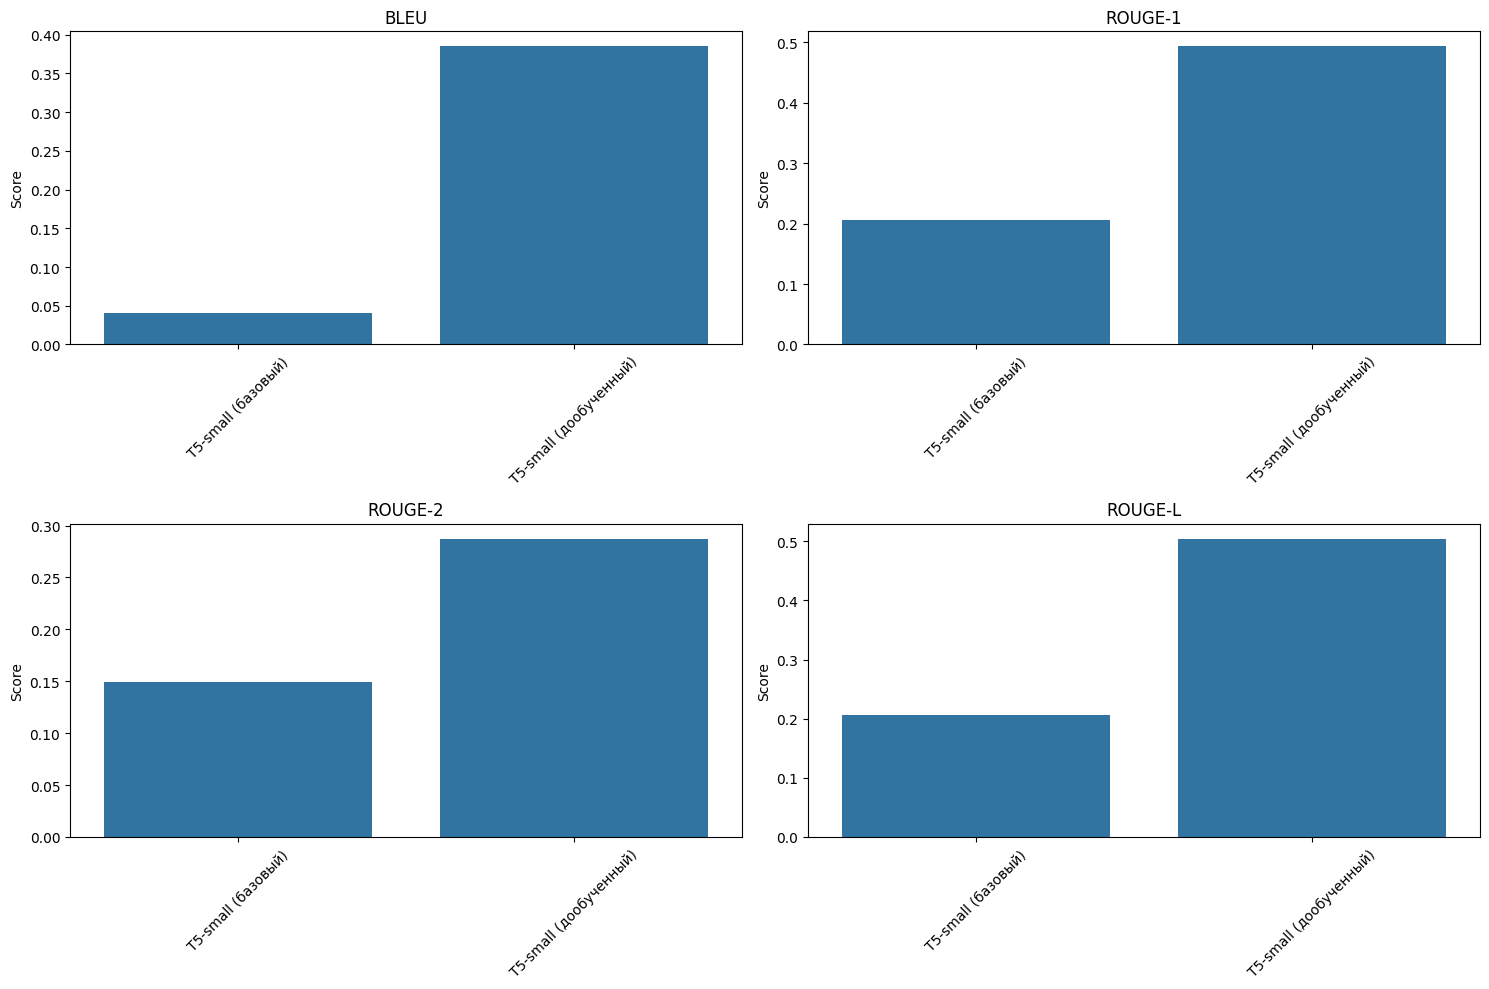


Анализ ошибок:
Средняя ошибка на уровне символов: 2.77%
Средняя ошибка на уровне слов: 2.94%


In [ ]:
results = {
    'T5-small (базовый)': {
        'BLEU': test_results.metrics['test_bleu'],
        'ROUGE-1': test_results.metrics['test_rouge1'],
        'ROUGE-2': test_results.metrics['test_rouge2'],
        'ROUGE-L': test_results.metrics['test_rougeL']
    },
    'T5-small (дообученный)': {
        'BLEU': final_results.metrics['test_bleu'],
        'ROUGE-1': final_results.metrics['test_rouge1'],
        'ROUGE-2': final_results.metrics['test_rouge2'],
        'ROUGE-L': final_results.metrics['test_rougeL']
    }
}

metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
models = list(results.keys())

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in models]
    sns.barplot(x=models, y=values, ax=axes[i])
    axes[i].set_title(metric)
    axes[i].set_ylabel('Score')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('metrics_comparison.png')
plt.show()


def calculate_error_types(predictions, references):
    char_level_errors = []
    word_level_errors = []

    for pred, ref in zip(predictions, references):
        char_diff = sum(1 for a, b in zip(pred, ref) if a != b) #Ошибки на уровне предложений.
        char_level_errors.append(char_diff / max(len(pred), len(ref)))

        pred_words = word_tokenize(pred) #Ошибки на уровне слов.
        ref_words = word_tokenize(ref)
        word_diff = sum(1 for a, b in zip(pred_words, ref_words) if a != b)
        word_level_errors.append(word_diff / max(len(pred_words), len(ref_words)))

    return {
        'mean_char_error': np.mean(char_level_errors),
        'mean_word_error': np.mean(word_level_errors)
    }

error_analysis = calculate_error_types(
    [tokenizer.decode(x, skip_special_tokens=True) for x in test_results.predictions],
    test_targets
)

print("\nАнализ ошибок:")
print(f"Средняя ошибка на уровне символов: {error_analysis['mean_char_error']:.2%}")
print(f"Средняя ошибка на уровне слов: {error_analysis['mean_word_error']:.2%}")

Визуализируется распределение длины предложений в словах как до, так и после исправления. Это позволяет оценить, насколько сильно изменяется структура предложений в результате предсказания модели.

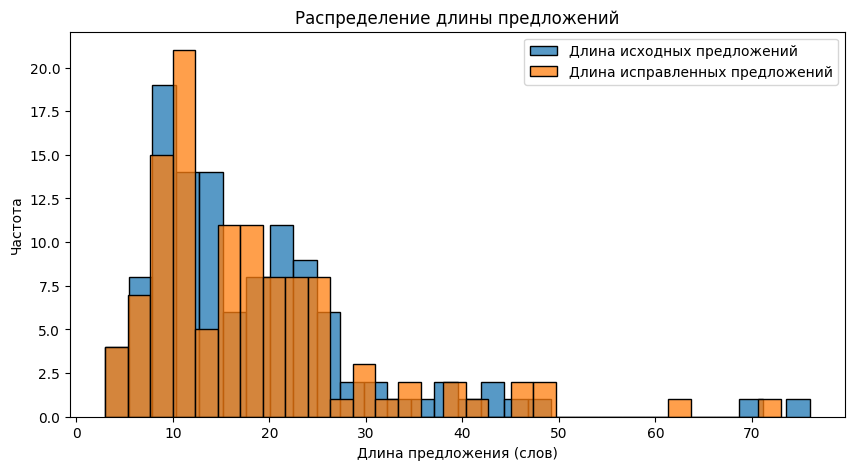

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot([len(x.split()) for x in test_sources], bins=30, label='Длина исходных предложений')
sns.histplot([len(x.split()) for x in test_targets], bins=30, label='Длина исправленных предложений')
plt.xlabel('Длина предложения (слов)')
plt.ylabel('Частота')
plt.title('Распределение длины предложений')
plt.legend()
plt.savefig('sentence_length_distribution.png')
plt.show()

Далее загружаем лучшую модель и часть реальной ВКР студента с финансового факультета. Делим её на куски и затем выводим первый попавшийся в 2х версиях: до исправления и после.

Шаги:
1. разбиения длинного текста на компактные фрагменты;
2. корректировка каждого фрагмента с использованием дообученной модели T5;
3. вывод пары до и после исправления для случайных примеров из текста.

In [ ]:
def split_text_into_chunks(text, chunk_size=200):
    sentences = text.split('. ')
    chunks = []
    current_chunk = ""
    for sentence in sentences:
        if len(current_chunk) + len(sentence) + 2 <= chunk_size:
            current_chunk += sentence + '. '
        else:
            chunks.append(current_chunk.strip())
            current_chunk = sentence + '. '
    if current_chunk:
        chunks.append(current_chunk.strip())
    return chunks

In [ ]:
def correct_text_with_model(text, model_path="./t5_jfleg_model_tr", max_input_length=128):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_input_length)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=128, num_beams=4, early_stopping=True)

    corrected_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return corrected_text

In [ ]:
def correct_file_and_show_pairs(input_path="FA extraction.txt", sample_size=5, chunk_size=200):
    with open(input_path, "r", encoding="utf-8") as f:
        full_text = f.read()
    chunks = split_text_into_chunks(full_text, chunk_size=chunk_size)
    selected_chunks = random.sample(chunks, min(sample_size, len(chunks)))

    for i, original_chunk in enumerate(selected_chunks, 1):
        corrected_chunk = correct_text_with_model(original_chunk)
        print(f"--- Фрагмент ---")
        print("До:")
        print(original_chunk)
        print("После:")
        print(corrected_chunk)
        print("----------------------\n")
        break


correct_file_and_show_pairs()


--- Фрагмент ---
До:
 Through regional budgets, dispairties in territroial social and ecnomic development are mitgated.
После:
 Through regional budgets, disparities in territorial social and economic development are mitigated.
----------------------


